# Multipair grid search template

This notebook serves as a basic template for any multipair backtest use case. You will need to change the strategy trading pairs, parameters and logic to suit to your purposes. But other parts of the notebooks like the data loading, grid search running, result and visualisation output can be left unchanged.

## MATIC and ETH breakout strategy

- An example bollinger bands based breakout strategy for MATIC and ETH token, using 1h candles. You have the option to either use onchain DEX data or Binance CEX data for backtesting.
- This is a breakout strategy, enter the position assuming price breakpoint when MATIC/ETH price exceeds RSI and Bollinger bands thresholds

## Set up

Set up the TradingStrategy data client

In [1]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()


# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/alex/.tradingstrategy


## Parameters

- Define the strategy parameters values used to make trading decisions

> **_NOTE:_**  The trading pairs should be defined outside the parameter class, as shown below. Also, do not call your class `StrategyParameters` as it is a reserved word.

In [2]:
import datetime

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import TradeRouting, ReserveCurrency
from tradeexecutor.strategy.parameters import StrategyParameters

# NOTE: the trading pairs should be defined outside the Parameters class
trading_pairs = [
    (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005), 
    (ChainId.polygon, "uniswap-v3", "WMATIC", "USDC", 0.0005), 
]

# Ether-USD Coin (PoS) https://tradingstrategy.ai/trading-view/polygon/uniswap-v3/eth-usdc-fee-5
# Wrapped Matic-USD Coin (PoS) https://tradingstrategy.ai/trading-view/polygon/uniswap-v3/matic-usdc-fee-5

class Parameters:

    id = "template-strategy-multi-pair-backtest"
    
    # load full range of data so we have enough lookback data
    # you can adjust this to a smaller range if you want
    # Note that dex data will start later than this depending on the DEX
    data_start = datetime.datetime(2019,1,1)
    data_end = datetime.datetime(2024,4,27)

    cycle_duration = CycleDuration.cycle_1h  # Run decide_trades() every 1h
    candle_time_bucket = TimeBucket.h1  # Which OHLCV candle time frame we use
    allocation = 0.98/len(trading_pairs)   # Cash allocation per open position, 49% per all cash
    
    # How many candles we load each decide_trades() cycle
    # We need 19 candles to calculate Bollinger Bands so use 20
    lookback_candle_count = 20 

    rsi_bars = 14  # Number of bars to calculate RSI for each trading bar
    bollinger_bands_ma_length = 19  # Bollinger bands 
    std_dev = 2.8

    rsi_entry = 50
    trailing_stop_loss = 0.98  # Trailing stop loss as 1 - x
    trailing_stop_loss_activation_level = 1.05  # How much above opening price we must be before starting to use trailing stop loss
    stop_loss = 0.98  # Hard stop loss when opening a new position

    #
    # Live trading only
    #
    chain_id = ChainId.polygon
    routing = TradeRouting.default  # Pick default routes for trade execution
    required_history_period = datetime.timedelta(hours=bollinger_bands_ma_length) * 2  # How much data our model needs to fill in the pipeline

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2023, 1, 1)
    backtest_end = datetime.datetime(2024, 4, 15)
    stop_loss_time_bucket = TimeBucket.m15  # use 15 minute close as the stop loss signal
    backtest_trading_fee = 0.0005  # Override the default Binance data trading fee and assume we can trade 5 BPS fee on WMATIC-USDC on Polygon on Uniswap v3
    initial_cash = 10_000

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

## Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting

> **_NOTE:_**  There are two ways to load data to your universe. You can either use our onchain (DEX) or Binance (CEX) data. 

### Onchain DEX data

In [3]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.trading_strategy_universe import load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context


def create_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:

    assert not execution_context.mode.is_live_trading(), \
        f"Only strategy backtesting supported, got {execution_context.mode}"

    # Load data for our trading pair whitelist
    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=trading_pairs,
        execution_context=execution_context,
        universe_options=universe_options,
        stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
    )

    # Filter down the dataset to the pairs we specified
    universe = TradingStrategyUniverse.create_multichain_universe_by_pair_descriptions(
        dataset,
        trading_pairs,
        reserve_token_symbol="USDC"  # Pick any USDC - does not matter as we do not route
    )

    return universe

universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles, {universe.universe.pairs.get_count()} trading pairs")

We loaded 22,554 candles, 2 trading pairs


### Binance data

Uncomment the code cell below to use Binance data instead of onchain data.

> **_NOTE:_**  Binance token symbols may be a bit different e.g. ETH instead of WETH. Go to https://api.binance.com/api/v3/exchangeInfo to see the full list of Binance trading pair tickers.

In [4]:
# from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
# from tradingstrategy.client import Client
# from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
# from tradeexecutor.utils.binance import create_binance_universe
# from tradeexecutor.strategy.universe_model import UniverseOptions

# trading_pairs = [
#     (ChainId.centralised_exchange, "binance", "ETH", "USDT", parameters.backtest_trading_fee),
#     (ChainId.centralised_exchange, "binance", "MATIC", "USDT", parameters.backtest_trading_fee),
# ]

# def create_trading_universe(
#     timestamp: datetime.datetime,
#     client: Client,
#     execution_context: ExecutionContext,
#     universe_options: UniverseOptions,
# ) -> TradingStrategyUniverse:
#     """Create the trading universe.

#     - For live trading, we load DEX data

#     - We backtest with Binance data, as it has more history
#     """

#     # Backtesting - load Binance data
#     strategy_universe = create_binance_universe(
#         [f"{p[2]}{p[3]}" for p in trading_pairs],
#         candle_time_bucket=Parameters.candle_time_bucket,
#         stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
#         start_at=Parameters.data_start,
#         end_at=Parameters.data_end,
#         trading_fee_override=Parameters.backtest_trading_fee,
#     )
#     return strategy_universe


# universe = create_trading_universe(
#     None,
#     client,
#     notebook_execution_context,
#     UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
# )

# Indicators

- Prepare indicators needed for the grid
- We use pandas_ta Python package to calculate technical indicators
- We use mfi, stochrsi, and ema indicators

In [5]:
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    indicators.add(
        "rsi",
        pandas_ta.rsi,
        {"length": parameters.rsi_bars}
    )

    indicators.add(
        "bbands",
        pandas_ta.bbands,
        {"length": parameters.bollinger_bands_ma_length, "std": parameters.std_dev},
    )
    return indicators

## Trading algorithm

- `decide_trades` function decide what trades to take
- Basically describes out trading strategy as code

In [6]:
from typing import List, Dict
import pandas as pd

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.trading_strategy_universe import translate_trading_pair

def decide_trades(
    input: StrategyInput,    
) -> List[TradeExecution]:

    # 
    # Decidion cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters: Parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe
    universe = strategy_universe.universe

    cash = position_manager.get_current_cash()
    
    trades = [] # must be defined outside for loop

    # Set up the load candle data for this decision frame,
    # We look back LOOKBACK_WINDOW candles.
    # Timestamp is the current open time, always make decision based on the last 
    # candle close, so adjust the end time minus one candle.
    start = timestamp - (parameters.lookback_candle_count * parameters.candle_time_bucket.to_pandas_timedelta())
    end = timestamp - parameters.candle_time_bucket.to_pandas_timedelta()  

    # Fetch candle data for all pairs in a single go
    candle_data = universe.candles.iterate_samples_by_pair_range(start, end)

    for pair_id, candles in candle_data:

        # Convert raw trading pair data to strategy execution format
        pair_data = universe.pairs.get_pair_by_id(pair_id)
        pair = translate_trading_pair(pair_data)

            # Read the indicator data for the current timestamp,
        # as calculated from the previous close value.
        # pandas_ta.bbands creates 3 series (columns) in its output
        #
        bollinger_bands_ma_length = parameters.bollinger_bands_ma_length
        std_dev = parameters.std_dev
        bb_upper_column = f"BBU_{bollinger_bands_ma_length}_{std_dev:.1f}" # pandas_ta internal column naming
        bb_mid_column = f"BBM_{bollinger_bands_ma_length}_{std_dev:.1f}" # pandas_ta internal column naming
        bb_lower_column = f"BBL_{bollinger_bands_ma_length}_{std_dev:.1f}" # pandas_ta internal column naming

        bb_upper = indicators.get_indicator_value("bbands", column=bb_upper_column, pair=pair, data_delay_tolerance=pd.Timedelta(hours=4))
        bb_mid = indicators.get_indicator_value("bbands", column=bb_mid_column, pair=pair, data_delay_tolerance=pd.Timedelta(hours=4))
        bb_lower = indicators.get_indicator_value("bbands", column=bb_lower_column, pair=pair, data_delay_tolerance=pd.Timedelta(hours=4))
        rsi = indicators.get_indicator_value("rsi", pair=pair, data_delay_tolerance=pd.Timedelta(hours=4))
        last_close_price = indicators.get_price(pair=pair)

        #
        # Trading logic
        #

        # Check if we are too early in the backtesting to have enough data to calculate indicators
        if None in (bb_upper, bb_mid, bb_lower, rsi):
            return []

        current_position_for_pair = position_manager.get_current_position_for_pair(pair)
        if not current_position_for_pair:
            # No open positions for pair, decide if BUY in this cycle.
            # We buy if the price on the daily chart closes above the upper Bollinger Band.
            if last_close_price > bb_upper and rsi > parameters.rsi_entry:
                buy_amount = cash * parameters.allocation
                trades += position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=parameters.stop_loss)

        else:
            # We have an open position for pair, decide if SELL in this cycle.
            # We close the position when the price closes below the X bars moving average.
            if last_close_price < bb_mid:
                trades += position_manager.close_position(current_position_for_pair)

            # Check if we have reached out level where we activate trailing stop loss
            current_position = position_manager.get_current_position_for_pair(pair)
            if last_close_price >= current_position.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                current_position.trailing_stop_loss_pct = parameters.trailing_stop_loss

        #
        # Visualisations
        #

        if input.is_visualisation_enabled():
            visualisation = state.visualisation  # Helper class to visualise strategy output
            symbol = pair.base.token_symbol

            # Draw bollinger price levels on the price chart
            visualisation.plot_indicator(timestamp, f"BB upper {symbol}", PlotKind.technical_indicator_on_price, bb_upper, colour="darkblue", pair=pair)
            visualisation.plot_indicator(timestamp, f"BB lower {symbol}", PlotKind.technical_indicator_on_price, bb_lower, colour="darkblue", pair=pair)
            visualisation.plot_indicator(timestamp, f"BB mid {symbol}", PlotKind.technical_indicator_on_price, bb_mid, colour="blue", pair=pair)

            # Draw the RSI indicator on a separate chart pane.
            # Visualise the high RSI threshold we must exceed to take a position.
            visualisation.plot_indicator(timestamp, f"RSI {symbol}", PlotKind.technical_indicator_detached, rsi)
            visualisation.plot_indicator(timestamp, f"RSI entry {symbol}", PlotKind.technical_indicator_overlay_on_detached, parameters.rsi_entry, colour="red", detached_overlay_name="RSI")

    return trades

## Backtest

- Run the backtest

In [7]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, diagnostics_data = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=universe,
    parameters=parameters,
    strategy_logging=False,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators rsi, bbands for 2 pairs, using 14 threads:   0%|          | 0/4 [00:00<?, ?it/s]

Using indicator cache /home/alex/.cache/indicators/polygon_1h_WETH-USDC-WMATIC-USDC_2023-01-01-2024-04-15


  0%|          | 0/40608000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 407 trades


## Equity curve

Equity curve shows how your strategy accrues value over time
A good equity curve has a stable ascending angle
Benchmark against MATIC and ETH buy and hold

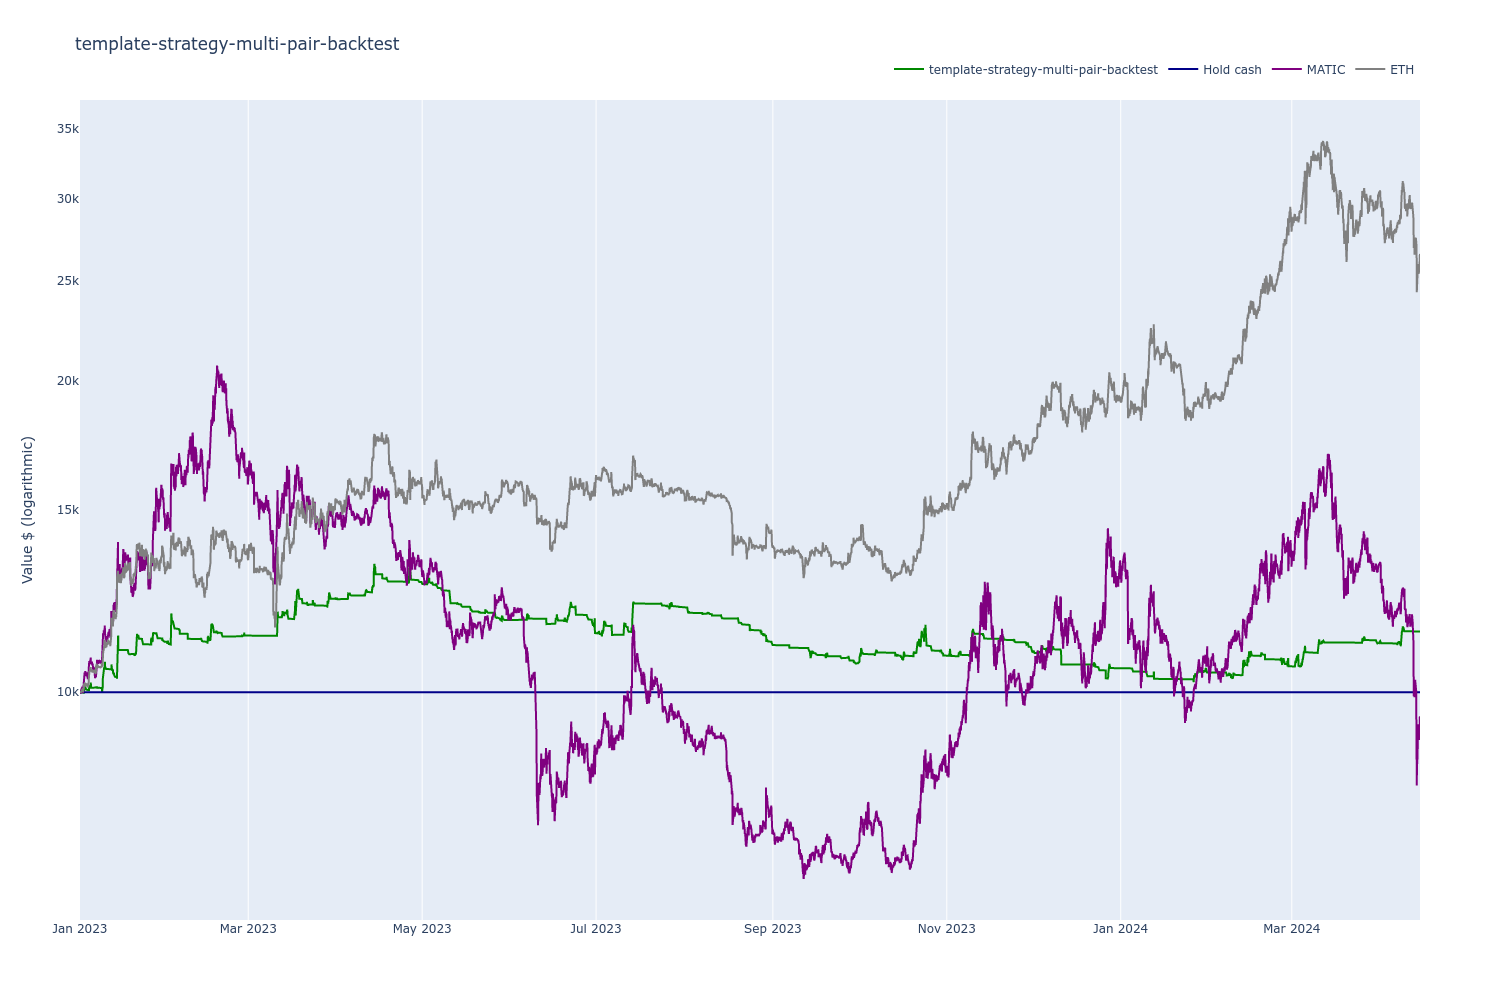

In [8]:
import pandas as pd
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

# Create ETH buy and hold benchmark
eth_desc = trading_pairs[0]
eth_pair = universe.data_universe.pairs.get_pair_by_human_description(eth_desc)

# Create MATIC buy and hold benchmark
matic_desc = trading_pairs[1]
matic_pair = universe.data_universe.pairs.get_pair_by_human_description(matic_desc)

benchmark_indexes = pd.DataFrame({
    "MATIC": universe.data_universe.candles.get_candles_by_pair(matic_pair)["close"],
    "ETH": universe.data_universe.candles.get_candles_by_pair(eth_pair)["close"]
})
benchmark_indexes["MATIC"].attrs = {"colour": "purple", "name": "Buy and hold MATIC"}
benchmark_indexes["ETH"].attrs = {"colour": "grey", "name": "Buy and hold ETH"}

fig = visualise_equity_curve_benchmark(
    name=state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_cash(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Technical indicator and trade visualisation

- Draw the technical indicators we filled in in decide_trades()
- Show the made trades on the price chart for a single trading pair
- You need to zoom in to see the bollinger bands, as the default chart width is full multi-year study. However the default notebook chart mode is static images, as interactive images are a bit slow on Github Codespaces.

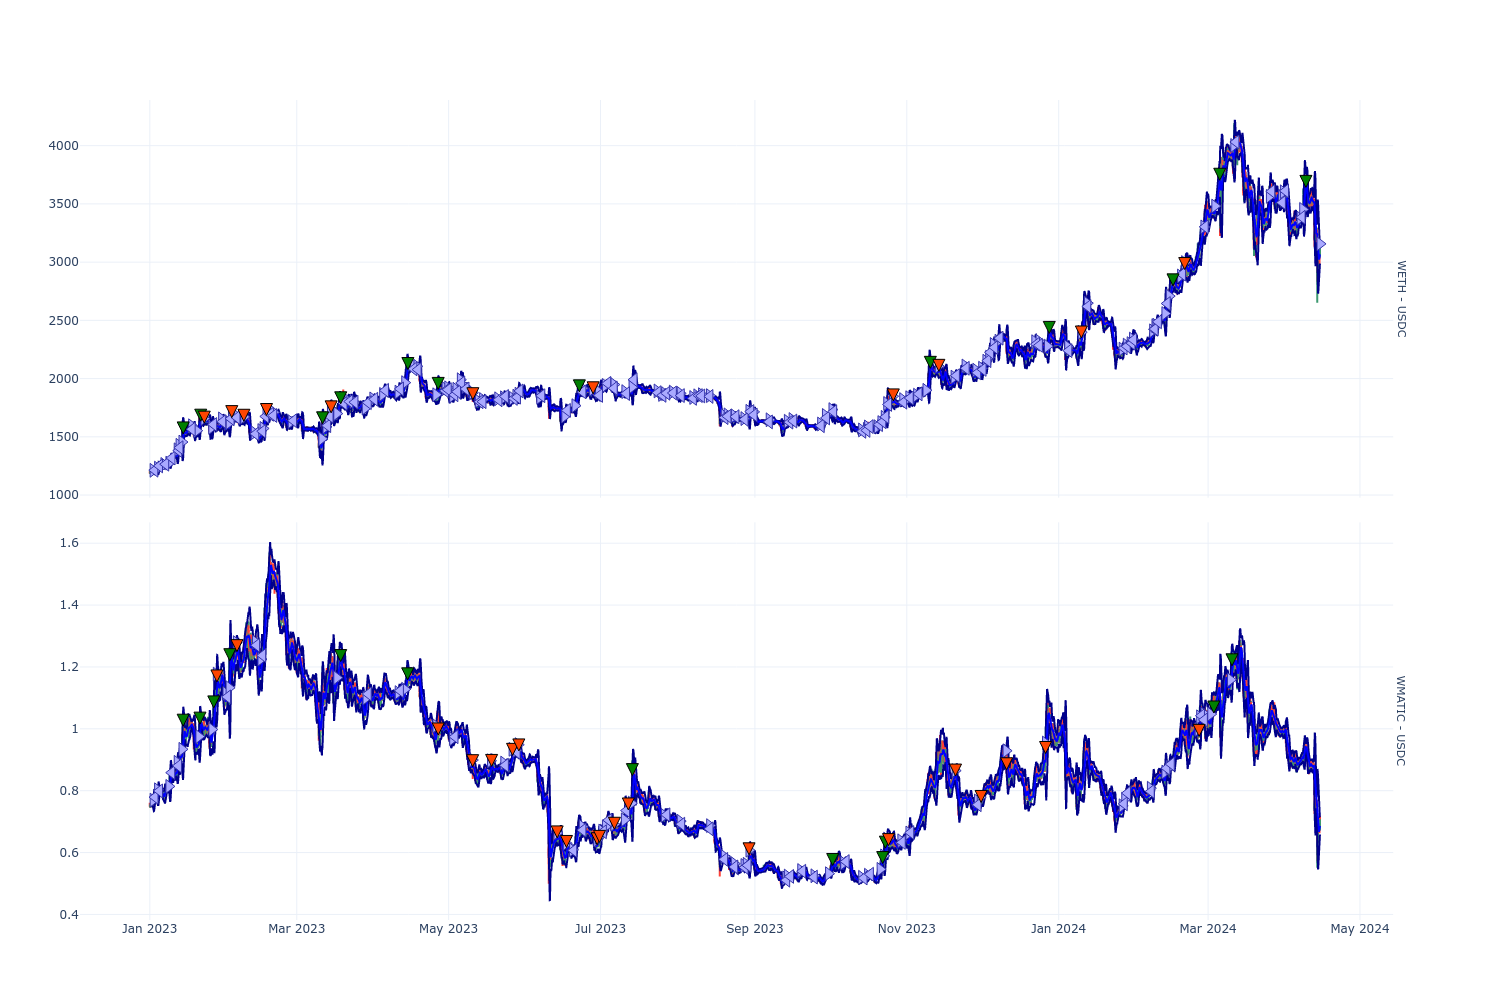

In [9]:
from tradeexecutor.visual.multiple_pairs import visualise_multiple_pairs
from tradingstrategy.charting.candle_chart import VolumeBarMode

start_at, end_at = state.get_strategy_start_and_end()   # Limit chart to our backtesting range

figure = visualise_multiple_pairs(
    state,
    execution_context=notebook_execution_context,
    candle_universe=universe.data_universe.candles,
    start_at=start_at,
    end_at=end_at,
    # volume_bar_mode=VolumeBarMode.hidden,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show()

## Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital. We can also compare against ETH if we want to.

In [10]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns, generate_buy_and_hold_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
benchmark_returns = generate_buy_and_hold_returns(benchmark_indexes["MATIC"])

metrics = visualise_advanced_metrics(
    returns,
    mode=AdvancedMetricsMode.full,
    benchmark=benchmark_returns,
    convert_to_daily=True,
)

display(metrics)

Strategy Buy and hold MATIC
Start Period               2023-01-01         2023-01-01
End Period                 2024-04-14         2024-04-14
Risk-Free Rate                   0.0%               0.0%
Time in Market                  50.0%              25.0%
Cumulative Return              14.47%            -100.0%
CAGR﹪                          11.09%            -100.0%
Sharpe                           0.68              -1.02
Prob. Sharpe Ratio             79.33%              13.2%
Smart Sharpe                     0.63              -0.95
Sortino                          1.43              -1.38
Smart Sortino                    1.32              -1.28
Sortino/√2                       1.01              -0.98
Smart Sortino/√2                 0.94               -0.9
Omega                            1.18               1.18
Max Drawdown                  -20.84%           -204.99%
Longest DD Days                   363                464
Volatility (ann.)               17.6%           10296.4%
R^2                               0.0                0.0
Information Ratio                0.05               0.05
Calmar                           0.53              -0.49
Skew                              3.1                0.2
Kurtosis                         16.9              94.97
Expected Daily                  0.03%            -100.0%
Expected Monthly                0.85%            -100.0%
Expected Yearly                 6.99%            -100.0%
Kelly Criterion                20.62%             -1.68%
Risk of Ruin                     0.0%               0.0%
Daily Value-at-Risk            -1.48%           -915.34%
Expected Shortfall (cVaR)      -1.48%           -915.34%
Max Consecutive Wins                5                  2
Max Consecutive Losses              5                  6
Gain/Pain Ratio                  0.18              -0.41
Gain/Pain (1M)                   0.56              -0.88
Payoff Ratio                     3.66               2.61
Profit Factor                    1.18               0.59
Common Sense Ratio               1.38               0.14
CPC Index                        1.63               0.41
Tail Ratio                       1.17               0.24
Outlier Win Ratio             1445.33               8.92
Outlier Loss Ratio            1035.62               1.61
MTD                             2.39%               0.0%
3M                             11.11%               0.0%
6M                               5.7%               0.0%
YTD                             8.48%               0.0%
1Y                             -9.54%            -100.0%
3Y (ann.)                      11.09%            -100.0%
5Y (ann.)                      11.09%            -100.0%
10Y (ann.)                     11.09%            -100.0%
All-time (ann.)                11.09%            -100.0%
Best Day                        6.61%           6722.83%
Worst Day                       -3.0%          -6081.74%
Best Month                     11.61%               0.0%
Worst Month                     -8.1%          -5640.22%
Best Year                       8.48%               0.0%
Worst Year                      5.52%            -100.0%
Avg. Drawdown                  -3.01%           -168.59%
Avg. Drawdown Days                 36                232
Recovery Factor                  0.69              -0.49
Ulcer Index                      0.13                1.0
Serenity Index                   0.05              -4.57
Avg. Up Month                       -                  -
Avg. Down Month                -7.67%            -100.0%
Win Days                       37.66%              26.5%
Win Month                       62.5%               0.0%
Win Quarter                     50.0%               0.0%
Win Year                       100.0%               0.0%
Beta                              0.0                  -
Alpha                            0.12                  -
Correlation                     1.73%                  -
Treynor Ratio              489713.94%  

## Trading statistics

- Display summary about trades made

In [11]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

## Rolling Sharpe

See how the six months rolling Sharpe ratio changes over time

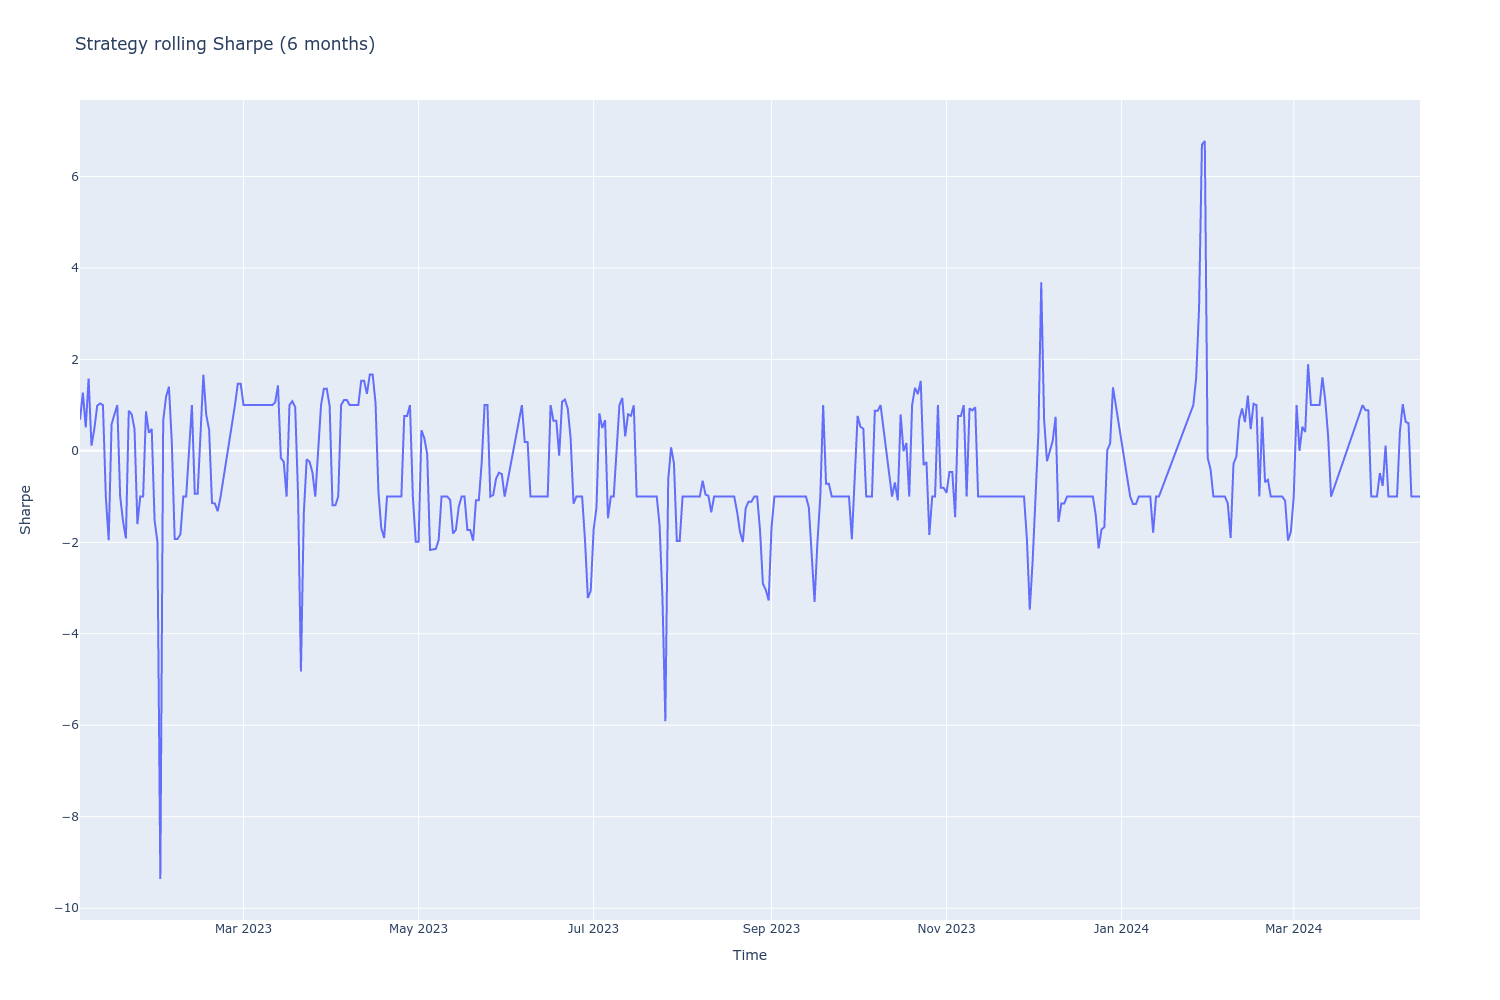

In [12]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=3,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()

## Finish

In [13]:
print("Notebook finished running successfully")

Notebook finished running successfully
